In [24]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from torch import nn
from torchmetrics import functional as FM
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class FaceDataset(Dataset):
    def __init__(self):
        df = pd.read_csv("./facial-keypoints-detection/training.csv")
        df = df.dropna()
        
        img_sep = df.iloc[:, -1].values.astype("str")
        img_sep = np.char.split(img_sep)
        img_sep = np.array(list(v.astype("float16") for v in list(map(np.array, img_sep))))
        self.inp = img_sep.reshape(df.__len__(), 96, 96)
        self.out = df.iloc[:, :-1].values
    
    def __len__(self):
        return len(self.inp)
    
    def __getitem__(self, idx):
        inp = torch.FloatTensor(self.inp[idx])
        outp = torch.FloatTensor(self.out[idx])
        return inp, outp

In [8]:
facedataset = FaceDataset()

In [9]:
facedataset.inp /= 255.0

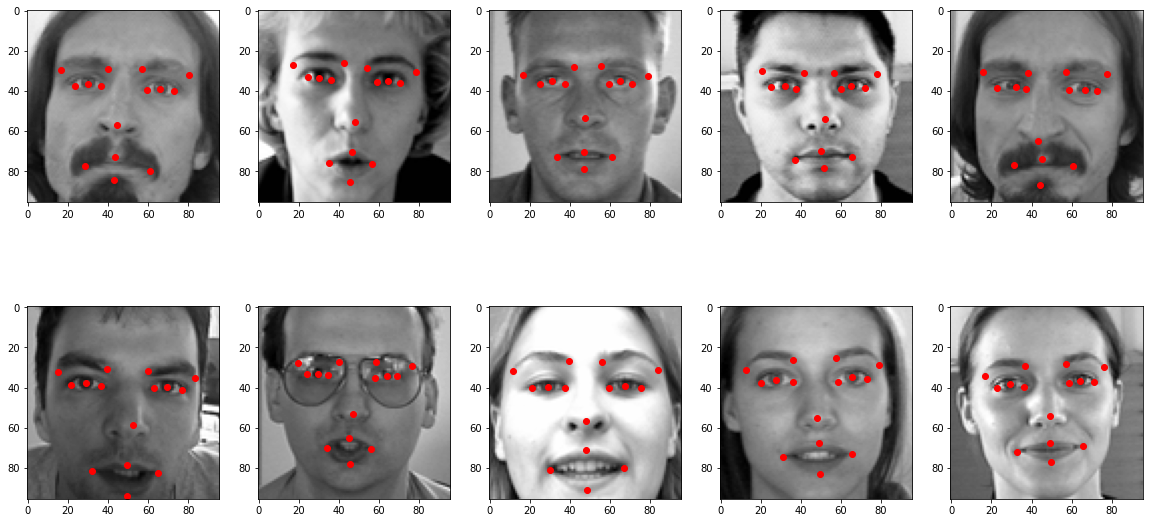

In [10]:
plt.figure(figsize=(20,10))
for i in range(10):
    image_index = i
    plt.subplot(2, 5, image_index+1)
    plt.imshow(facedataset.inp[image_index], cmap="gray")

    for index, a in enumerate(facedataset.out[image_index]):
        if index == 30:
            break
        if index%2 == 1:
            plt.plot(facedataset.out[image_index][index-1], a, marker='o', color="red")

In [11]:
train, val = random_split(facedataset, [2033, 107])

In [12]:
train_dataloader = DataLoader(train, batch_size=16)
val_dataloader = DataLoader(val, batch_size=16)

In [13]:
testdf = pd.read_csv("./facial-keypoints-detection/test.csv")
testsets = np.array(list(v.astype("float16") for v in list(map(np.array, np.char.split(testdf.Image.values.astype("str"))))))/255.0
testsets = testsets.reshape(-1, 96, 96)

In [14]:
def scaledsigmoid(x):
    return 96.0 * torch.sigmoid(x)

class ScaledSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        return scaledsigmoid(input)

In [15]:
class PrintOnEpoch(Callback):
    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module):
        print("\n", trainer.logged_metrics)

In [16]:
train_loss_list = []
val_loss_list = []
class FacialRegressor(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*5*5, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 30),
            ScaledSigmoid()
        )
        
    def forward(self, batch):
        batch = batch.view(-1, 1, 96, 96)
        return self.fc(self.conv(batch))

    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self(X)
        loss = F.mse_loss(logits, y)
        loss = torch.sqrt(loss)
        train_loss_list.append(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            X, y = batch
            pred = self(X)
            val_loss = F.mse_loss(pred, y)
            val_loss = torch.sqrt(val_loss)
            val_loss_list.append(val_loss)
            self.log("val_loss", val_loss)
            return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.mse_loss(pred, y)
        loss = torch.sqrt(loss)
        self.log("test_loss", loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr=1e-3)
        return optimizer

In [25]:
model = FacialRegressor()
earlystop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, callbacks=[PrintOnEpoch(), earlystop_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 4.6 M 
1 | fc   | Sequential | 6.7 M 
------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.488    Total estimated model params size (MB)


d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 135/135 [00:06<00:00, 19.43it/s, loss=5.06, v_num=53]
 {'val_loss': tensor(3.3648, device='cuda:0')}


Metric val_loss improved. New best score: 3.365


Epoch 1: 100%|██████████| 135/135 [00:06<00:00, 19.35it/s, loss=3.85, v_num=53]

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 3.213



 {'val_loss': tensor(3.2130, device='cuda:0')}
Epoch 2: 100%|██████████| 135/135 [00:06<00:00, 19.29it/s, loss=3.69, v_num=53]
 {'val_loss': tensor(3.1272, device='cuda:0')}


Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 3.127


Epoch 3: 100%|██████████| 135/135 [00:06<00:00, 19.37it/s, loss=3.49, v_num=53]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 3.103



 {'val_loss': tensor(3.1033, device='cuda:0')}
Epoch 4: 100%|██████████| 135/135 [00:06<00:00, 19.35it/s, loss=3.37, v_num=53]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 3.063



 {'val_loss': tensor(3.0625, device='cuda:0')}
Epoch 5: 100%|██████████| 135/135 [00:06<00:00, 19.48it/s, loss=3.37, v_num=53]
 {'val_loss': tensor(3.1526, device='cuda:0')}
Epoch 6: 100%|██████████| 135/135 [00:06<00:00, 19.41it/s, loss=3.33, v_num=53]
 {'val_loss': tensor(3.1321, device='cuda:0')}
Epoch 7: 100%|██████████| 135/135 [00:06<00:00, 19.35it/s, loss=3.23, v_num=53]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 3.055



 {'val_loss': tensor(3.0554, device='cuda:0')}
Epoch 8: 100%|██████████| 135/135 [00:06<00:00, 19.35it/s, loss=3.34, v_num=53]
 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.052


{'val_loss': tensor(3.0523, device='cuda:0')}
Epoch 9: 100%|██████████| 135/135 [00:06<00:00, 19.33it/s, loss=3.26, v_num=53]
 {'val_loss': tensor(3.0528, device='cuda:0')}
Epoch 10: 100%|██████████| 135/135 [00:06<00:00, 19.33it/s, loss=3.27, v_num=53]
 {'val_loss': tensor(3.0841, device='cuda:0')}
Epoch 11: 100%|██████████| 135/135 [00:06<00:00, 19.31it/s, loss=3.16, v_num=53]
 {'val_loss': tensor(3.0602, device='cuda:0')}
Epoch 12: 100%|██████████| 135/135 [00:07<00:00, 19.23it/s, loss=3.25, v_num=53]
 {'val_loss': tensor(3.0577, device='cuda:0')}
Epoch 13: 100%|██████████| 135/135 [00:06<00:00, 19.29it/s, loss=3.32, v_num=53]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.050



 {'val_loss': tensor(3.0497, device='cuda:0')}
Epoch 14: 100%|██████████| 135/135 [00:07<00:00, 19.27it/s, loss=3.24, v_num=53]
 {'val_loss': tensor(3.0642, device='cuda:0')}
Epoch 15: 100%|██████████| 135/135 [00:07<00:00, 19.23it/s, loss=3.2, v_num=53] 
 {'val_loss': tensor(3.0527, device='cuda:0')}
Epoch 16: 100%|██████████| 135/135 [00:07<00:00, 19.26it/s, loss=3.2, v_num=53] 
 {'val_loss': tensor(3.0819, device='cuda:0')}
Epoch 17: 100%|██████████| 135/135 [00:07<00:00, 19.25it/s, loss=3.1, v_num=53] 
 {'val_loss': tensor(3.0931, device='cuda:0')}
Epoch 18: 100%|██████████| 135/135 [00:07<00:00, 19.20it/s, loss=3.26, v_num=53]
 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.049


{'val_loss': tensor(3.0489, device='cuda:0')}
Epoch 19: 100%|██████████| 135/135 [00:07<00:00, 19.09it/s, loss=3.13, v_num=53]
 {'val_loss': tensor(3.0643, device='cuda:0')}
Epoch 20: 100%|██████████| 135/135 [00:07<00:00, 19.16it/s, loss=3.15, v_num=53]
 {'val_loss': tensor(3.0584, device='cuda:0')}
Epoch 21: 100%|██████████| 135/135 [00:06<00:00, 19.29it/s, loss=3.14, v_num=53]
 {'val_loss': tensor(3.0573, device='cuda:0')}
Epoch 22: 100%|██████████| 135/135 [00:07<00:00, 19.12it/s, loss=3.11, v_num=53]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.049



 {'val_loss': tensor(3.0488, device='cuda:0')}
Epoch 23: 100%|██████████| 135/135 [00:07<00:00, 19.09it/s, loss=3.14, v_num=53]
 {'val_loss': tensor(3.0596, device='cuda:0')}
Epoch 24: 100%|██████████| 135/135 [00:07<00:00, 19.22it/s, loss=3.17, v_num=53]
 {'val_loss': tensor(3.0549, device='cuda:0')}
Epoch 25: 100%|██████████| 135/135 [00:07<00:00, 19.21it/s, loss=3.11, v_num=53]
 {'val_loss': tensor(3.0619, device='cuda:0')}
Epoch 26: 100%|██████████| 135/135 [00:07<00:00, 19.14it/s, loss=3.12, v_num=53]
 {'val_loss': tensor(3.0528, device='cuda:0')}
Epoch 27: 100%|██████████| 135/135 [00:07<00:00, 19.20it/s, loss=3.11, v_num=53]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.049. Signaling Trainer to stop.



 {'val_loss': tensor(3.0573, device='cuda:0')}
Epoch 27: 100%|██████████| 135/135 [00:08<00:00, 15.39it/s, loss=3.11, v_num=53]


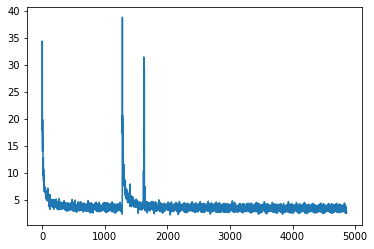

In [26]:
plt.plot([i.item() for i in train_loss_list])

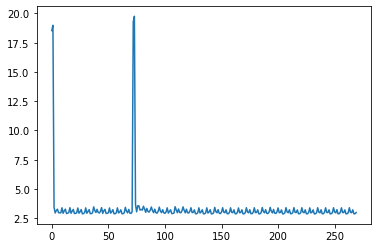

In [27]:
plt.plot([i.item() for i in val_loss_list])

In [28]:
with torch.no_grad():
    trainer.test(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 59.31it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.05729079246521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [29]:
def draw_validout(model):
    plt.figure(figsize=(20, 10))
    for x, y in val_dataloader:
        images = x
        result = y
        break;
    images = images[:10]
    result = result[:10]
    
    for i in range(10):
        test_index=i
        out = model(torch.FloatTensor(images[i]))

        plt.subplot(2, 5, i+1)
        plt.imshow(images[test_index], cmap="gray")

        for index, a in enumerate(result[i].detach().numpy()):
            if index == 30:
                break
            if index%2 == 1:
                plt.plot(result[i][index-1].item(), a, marker='o', color="red")
                plt.plot(out[0][index-1].item(), out[0][index].item(), marker='o', color="blue")
        

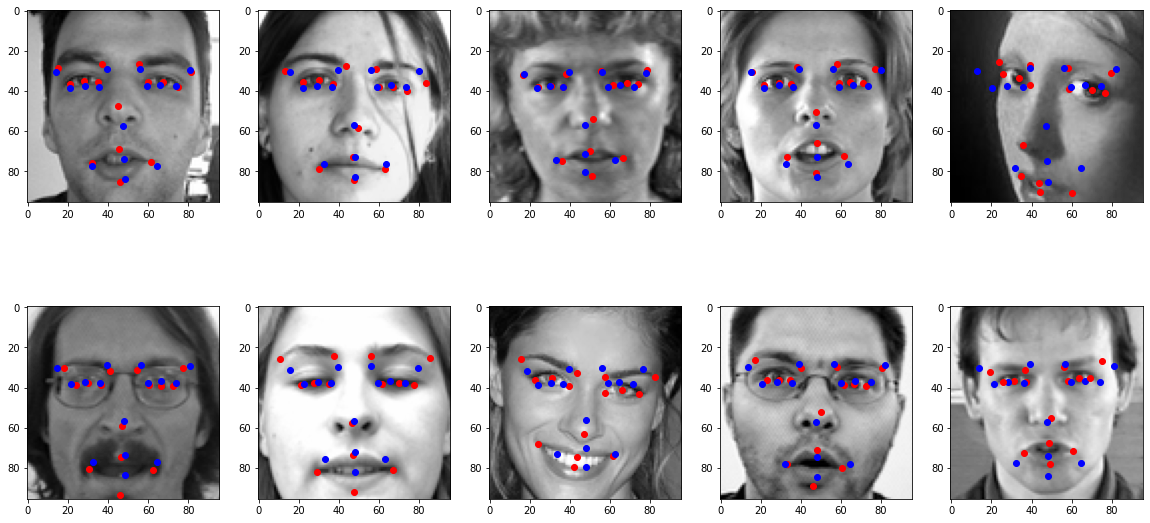

In [30]:
draw_validout(model)

In [37]:
def draw_testout(model):
    plt.figure(figsize=(20, 10))
    for i in range(10):
        test_index=i
        out = model(torch.FloatTensor(testsets[test_index]))

        plt.subplot(2, 5, i+1)
        plt.imshow(testsets[test_index], cmap="gray")

        for index, a in enumerate(out[0].cpu().detach().numpy()):
            if index == 30:
                break
            if index%2 == 1:
                plt.plot(out[0][index-1].item(), a, marker='o', color="red")

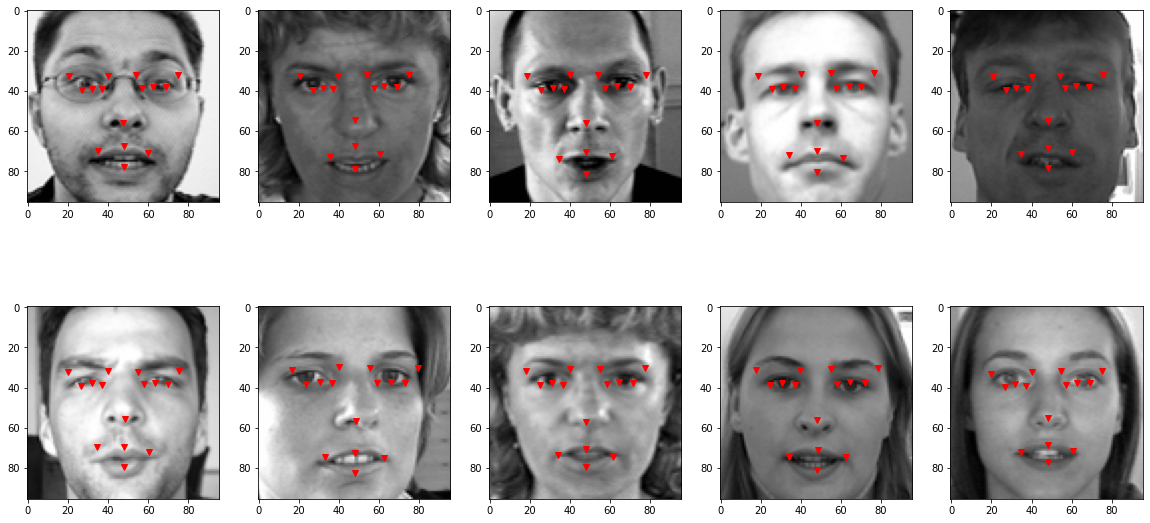

In [52]:
draw_testout(model)

In [31]:
def save_res(model):
    totalout = []
    for input in testsets:
        pred = model(torch.FloatTensor(input))
        totalout.append(pred[0].detach().numpy())    

    idl = pd.read_csv("./facial-keypoints-detection/IdLookupTable.csv")
    tc = pd.read_csv("./facial-keypoints-detection/training.csv")

    return_csv = []
    for index, row in idl.iterrows():
        res = totalout[row["ImageId"]-1][tc.columns.get_loc(row["FeatureName"])]
        if res>96:
            res = 96.
        elif res<0:
            res = 0.
        return_csv.append(res)

    index = list(range(1, 27125))

    out = pd.DataFrame(zip(index, return_csv), columns=["RowId", "Location"])
    out.to_csv('./out.csv', index=False)

In [32]:
save_res(model)     # 4.35620

--------------------

In [41]:
train_loss_list = []
val_loss_list = []
class FacialRegressor(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.example_input_array = torch.Tensor(16, 1, 96, 96)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same', bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 30),
            ScaledSigmoid()
        )
        
    def forward(self, batch):
        batch = batch.view(-1, 1, 96, 96)
        return self.fc(self.conv(batch))

    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self(X)
        loss = F.mse_loss(logits, y)
        loss = torch.sqrt(loss)
        train_loss_list.append(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            X, y = batch
            pred = self(X)
            val_loss = F.mse_loss(pred, y)
            val_loss = torch.sqrt(val_loss)
            val_loss_list.append(val_loss)
            self.log("val_loss", val_loss.item())
            return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.mse_loss(pred, y)
        loss = torch.sqrt(loss)
        self.log("test_loss", loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr=1e-3)
        return optimizer

In [42]:
model = FacialRegressor()
earlystop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, callbacks=[ModelSummary(max_depth=-1), PrintOnEpoch(), earlystop_callback])
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type          | Params | In sizes          | Out sizes        
-----------------------------------------------------------------------------------
0  | conv    | Sequential    | 4.9 M  | [16, 1, 96, 96]   | [16, 512, 3, 3]  
1  | conv.0  | Conv2d        | 288    | [16, 1, 96, 96]   | [16, 32, 96, 96] 
2  | conv.1  | LeakyReLU     | 0      | [16, 32, 96, 96]  | [16, 32, 96, 96] 
3  | conv.2  | BatchNorm2d   | 64     | [16, 32, 96, 96]  | [16, 32, 96, 96] 
4  | conv.3  | Conv2d        | 9.2 K  | [16, 32, 96, 96]  | [16, 32, 96, 96] 
5  | conv.4  | LeakyReLU     | 0      | [16, 32, 96, 96]  | [16, 32, 96, 96] 
6  | 

Epoch 0: 100%|██████████| 135/135 [00:04<00:00, 27.20it/s, loss=6.2, v_num=57] 

Metric val_loss improved. New best score: 4.724



 {'val_loss': tensor(4.7242, device='cuda:0')}
Epoch 1: 100%|██████████| 135/135 [00:05<00:00, 26.91it/s, loss=4.87, v_num=57]
 {'val_loss': tensor(4.8599, device='cuda:0')}
Epoch 2: 100%|██████████| 135/135 [00:04<00:00, 27.04it/s, loss=4.66, v_num=57]
 {'val_loss': tensor(5.8509, device='cuda:0')}
Epoch 3: 100%|██████████| 135/135 [00:05<00:00, 26.92it/s, loss=4.05, v_num=57]
 {'val_loss': tensor(5.4998, device='cuda:0')}
Epoch 4: 100%|██████████| 135/135 [00:05<00:00, 26.65it/s, loss=3.44, v_num=57]

Metric val_loss improved by 1.588 >= min_delta = 0.0. New best score: 3.137



 {'val_loss': tensor(3.1365, device='cuda:0')}
Epoch 5: 100%|██████████| 135/135 [00:05<00:00, 26.85it/s, loss=3.36, v_num=57]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 3.080



 {'val_loss': tensor(3.0800, device='cuda:0')}
Epoch 6: 100%|██████████| 135/135 [00:05<00:00, 26.65it/s, loss=3.35, v_num=57]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 3.056



 {'val_loss': tensor(3.0558, device='cuda:0')}
Epoch 7: 100%|██████████| 135/135 [00:05<00:00, 26.71it/s, loss=3.23, v_num=57]
 {'val_loss': tensor(3.0718, device='cuda:0')}
Epoch 8: 100%|██████████| 135/135 [00:05<00:00, 26.91it/s, loss=3.22, v_num=57]
 {'val_loss': tensor(3.0561, device='cuda:0')}
Epoch 9: 100%|██████████| 135/135 [00:05<00:00, 26.76it/s, loss=3.2, v_num=57] 
 {'val_loss': tensor(3.0621, device='cuda:0')}
Epoch 10: 100%|██████████| 135/135 [00:04<00:00, 27.08it/s, loss=3.15, v_num=57]
 {'val_loss': tensor(3.0630, device='cuda:0')}
Epoch 11: 100%|██████████| 135/135 [00:05<00:00, 26.91it/s, loss=3.21, v_num=57]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.056. Signaling Trainer to stop.



 {'val_loss': tensor(3.0763, device='cuda:0')}
Epoch 11: 100%|██████████| 135/135 [00:06<00:00, 22.03it/s, loss=3.21, v_num=57]


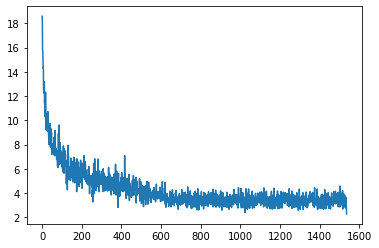

In [43]:
plt.plot([i.item() for i in train_loss_list])

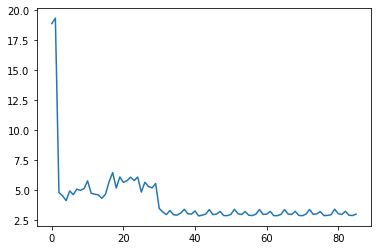

In [44]:
plt.plot([i.item() for i in val_loss_list])

In [47]:
trainer.test(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 111.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.0771586894989014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.0771586894989014}]

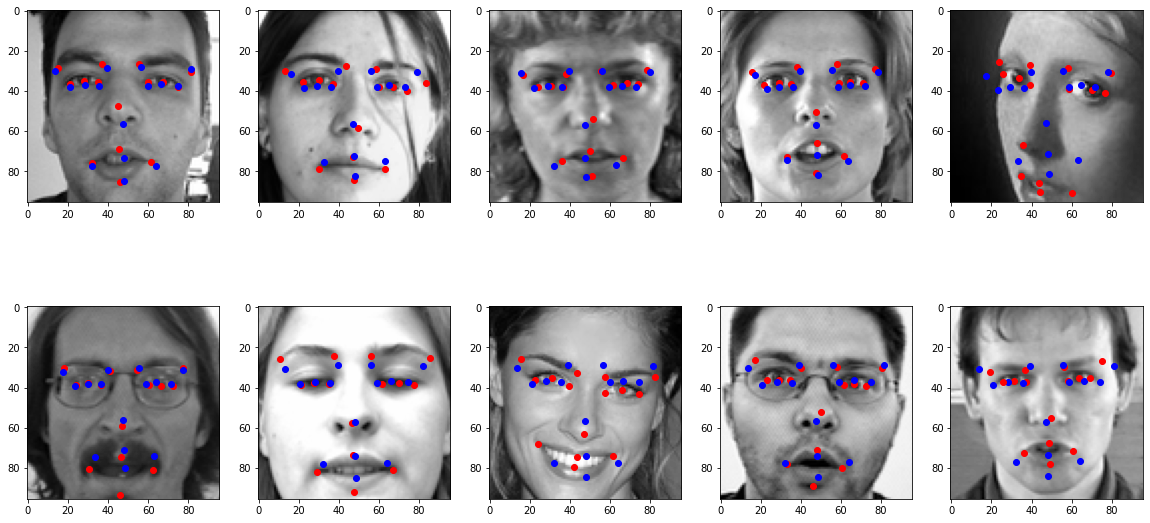

In [46]:
draw_validout(model)

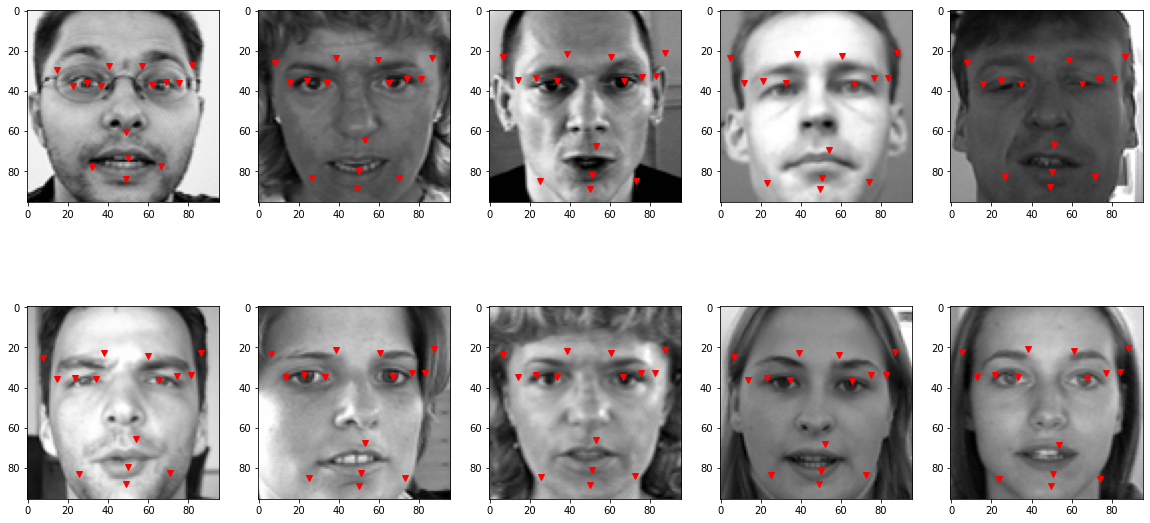

In [96]:
draw_testout(model)

In [48]:
save_res(model)

-----------------------

In [67]:
class FacialRegressor(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.example_input_array = torch.Tensor(16, 1, 96, 96)
        self.scheduler = ReduceLROnPlateau(model.configure_optimizers(), mode="min", factor=0.7, patience=5, min_lr=1e-15, verbose=True)
        self.first_conv_layer = nn.Sequential(
            nn.Conv2d(1, 3, 1, stride=1, padding='same', bias=True),
            nn.LeakyReLU(0.1)
        )
        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        
        num_target_classes = 30
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_filters, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_target_classes),
            ScaledSigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 1, 96, 96)
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(self.first_conv_layer(x)).flatten(1)
        x = self.classifier(representations)
        return x
        
    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self.forward(X)
        loss = F.mse_loss(logits, y)
        loss = torch.sqrt(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            X, y = batch
            pred = self(X)
            val_loss = F.mse_loss(pred, y)
            val_loss = torch.sqrt(val_loss)
            val_loss_list.append(val_loss)
            self.log("val_loss", val_loss.item())
        self.scheduler.step(val_loss)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            X, y = batch
            pred = self(X)
        loss = F.mse_loss(pred, y)
        loss = torch.sqrt(loss)
        self.log("test_loss", loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), 1e-3)
        return optimizer

In [70]:
print(model)

FacialRegressor(
  (first_conv_layer): Sequential(
    (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2

In [69]:
model = FacialRegressor()

In [71]:
earlystop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices=1, callbacks=[PrintOnEpoch(), earlystop_callback])
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | In sizes        | Out sizes       
--------------------------------------------------------------------------------------
0 | first_conv_layer  | Sequential | 6      | [16, 1, 96, 96] | [16, 3, 96, 96] 
1 | feature_extractor | Sequential | 23.5 M | [16, 3, 96, 96] | [16, 2048, 1, 1]
2 | classifier        | Sequential | 1.1 M  | [16, 2048]      | [16, 30]        
--------------------------------------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.290    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 37.04it/s]

d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 135/135 [00:03<00:00, 34.03it/s, loss=4.94, v_num=60]

Metric val_loss improved. New best score: 4.873



 {'val_loss': tensor(4.8729, device='cuda:0')}
Epoch 1: 100%|██████████| 135/135 [00:03<00:00, 37.09it/s, loss=4.45, v_num=60]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 4.755



 {'val_loss': tensor(4.7547, device='cuda:0')}
Epoch 2: 100%|██████████| 135/135 [00:03<00:00, 35.73it/s, loss=4.22, v_num=60]
 {'val_loss': tensor(6.4420, device='cuda:0')}
Epoch 3: 100%|██████████| 135/135 [00:03<00:00, 36.85it/s, loss=3.89, v_num=60]

Metric val_loss improved by 0.585 >= min_delta = 0.0. New best score: 4.170



 {'val_loss': tensor(4.1696, device='cuda:0')}
Epoch 4: 100%|██████████| 135/135 [00:03<00:00, 36.42it/s, loss=3.81, v_num=60]
 {'val_loss': tensor(4.8224, device='cuda:0')}
Epoch 5: 100%|██████████| 135/135 [00:03<00:00, 36.44it/s, loss=3.58, v_num=60]
 {'val_loss': tensor(6.8133, device='cuda:0')}
Epoch 6: 100%|██████████| 135/135 [00:03<00:00, 37.43it/s, loss=3.5, v_num=60]

Metric val_loss improved by 0.264 >= min_delta = 0.0. New best score: 3.906



 {'val_loss': tensor(3.9056, device='cuda:0')}
Epoch 7: 100%|██████████| 135/135 [00:03<00:00, 36.38it/s, loss=3.49, v_num=60]

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 3.716



 {'val_loss': tensor(3.7164, device='cuda:0')}
Epoch 8: 100%|██████████| 135/135 [00:03<00:00, 36.70it/s, loss=3.48, v_num=60]
 {'val_loss': tensor(5.0202, device='cuda:0')}
Epoch 9: 100%|██████████| 135/135 [00:03<00:00, 37.98it/s, loss=3.26, v_num=60]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 3.630



 {'val_loss': tensor(3.6304, device='cuda:0')}
Epoch 10: 100%|██████████| 135/135 [00:03<00:00, 36.40it/s, loss=3.2, v_num=60]
 {'val_loss': tensor(5.4148, device='cuda:0')}
Epoch 11: 100%|██████████| 135/135 [00:03<00:00, 36.94it/s, loss=3.18, v_num=60]

Metric val_loss improved by 0.473 >= min_delta = 0.0. New best score: 3.157



 {'val_loss': tensor(3.1574, device='cuda:0')}
Epoch 12: 100%|██████████| 135/135 [00:03<00:00, 35.37it/s, loss=3.13, v_num=60]
 {'val_loss': tensor(3.1641, device='cuda:0')}
Epoch 13: 100%|██████████| 135/135 [00:03<00:00, 36.09it/s, loss=3.05, v_num=60]
 {'val_loss': tensor(3.7060, device='cuda:0')}
Epoch 14: 100%|██████████| 135/135 [00:03<00:00, 36.40it/s, loss=3.03, v_num=60]

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 3.043



 {'val_loss': tensor(3.0429, device='cuda:0')}
Epoch 15: 100%|██████████| 135/135 [00:03<00:00, 36.47it/s, loss=2.9, v_num=60]
 {'val_loss': tensor(3.4666, device='cuda:0')}
Epoch 16: 100%|██████████| 135/135 [00:03<00:00, 35.85it/s, loss=2.82, v_num=60]
 {'val_loss': tensor(3.4115, device='cuda:0')}
Epoch 17: 100%|██████████| 135/135 [00:03<00:00, 35.52it/s, loss=2.84, v_num=60]
 {'val_loss': tensor(3.7659, device='cuda:0')}
Epoch 18: 100%|██████████| 135/135 [00:03<00:00, 35.60it/s, loss=2.84, v_num=60]
 {'val_loss': tensor(3.1086, device='cuda:0')}
Epoch 19: 100%|██████████| 135/135 [00:03<00:00, 34.77it/s, loss=2.85, v_num=60]

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 2.888



 {'val_loss': tensor(2.8885, device='cuda:0')}
Epoch 20: 100%|██████████| 135/135 [00:04<00:00, 29.09it/s, loss=2.75, v_num=60]
 {'val_loss': tensor(3.5994, device='cuda:0')}
Epoch 21: 100%|██████████| 135/135 [00:04<00:00, 32.14it/s, loss=2.72, v_num=60]
 {'val_loss': tensor(3.0845, device='cuda:0')}
Epoch 22: 100%|██████████| 135/135 [00:04<00:00, 31.99it/s, loss=2.81, v_num=60]
 {'val_loss': tensor(3.2394, device='cuda:0')}
Epoch 23: 100%|██████████| 135/135 [00:03<00:00, 35.53it/s, loss=2.74, v_num=60]
 {'val_loss': tensor(2.8959, device='cuda:0')}
Epoch 24: 100%|██████████| 135/135 [00:03<00:00, 34.61it/s, loss=2.62, v_num=60]

Metric val_loss improved by 0.286 >= min_delta = 0.0. New best score: 2.602



 {'val_loss': tensor(2.6024, device='cuda:0')}
Epoch 25: 100%|██████████| 135/135 [00:03<00:00, 36.64it/s, loss=2.63, v_num=60]
 {'val_loss': tensor(2.7523, device='cuda:0')}
Epoch 26: 100%|██████████| 135/135 [00:03<00:00, 35.70it/s, loss=2.6, v_num=60]
 {'val_loss': tensor(2.4481, device='cuda:0')}


Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 2.448


Epoch 27: 100%|██████████| 135/135 [00:04<00:00, 33.12it/s, loss=2.59, v_num=60]
 {'val_loss': tensor(2.4999, device='cuda:0')}
Epoch 28: 100%|██████████| 135/135 [00:03<00:00, 33.92it/s, loss=2.53, v_num=60]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.439



 {'val_loss': tensor(2.4389, device='cuda:0')}
Epoch 29: 100%|██████████| 135/135 [00:04<00:00, 31.00it/s, loss=2.56, v_num=60]
 {'val_loss': tensor(2.4403, device='cuda:0')}
Epoch 30: 100%|██████████| 135/135 [00:03<00:00, 35.61it/s, loss=2.56, v_num=60]
 {'val_loss': tensor(2.4942, device='cuda:0')}
Epoch 31: 100%|██████████| 135/135 [00:03<00:00, 37.42it/s, loss=2.56, v_num=60]
 {'val_loss': tensor(2.4402, device='cuda:0')}
Epoch 32: 100%|██████████| 135/135 [00:03<00:00, 35.91it/s, loss=2.5, v_num=60] 
 {'val_loss': tensor(2.4516, device='cuda:0')}
Epoch 33: 100%|██████████| 135/135 [00:05<00:00, 24.73it/s, loss=2.48, v_num=60]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.399



 {'val_loss': tensor(2.3988, device='cuda:0')}
Epoch 34: 100%|██████████| 135/135 [00:03<00:00, 35.70it/s, loss=2.53, v_num=60]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 2.387



 {'val_loss': tensor(2.3868, device='cuda:0')}
Epoch 35: 100%|██████████| 135/135 [00:03<00:00, 35.37it/s, loss=2.58, v_num=60]
 {'val_loss': tensor(2.6034, device='cuda:0')}
Epoch 36: 100%|██████████| 135/135 [00:03<00:00, 36.06it/s, loss=2.48, v_num=60]
 {'val_loss': tensor(2.5431, device='cuda:0')}
Epoch 37: 100%|██████████| 135/135 [00:03<00:00, 37.14it/s, loss=2.55, v_num=60]
 {'val_loss': tensor(2.4555, device='cuda:0')}
Epoch 38: 100%|██████████| 135/135 [00:03<00:00, 37.37it/s, loss=2.48, v_num=60]
 {'val_loss': tensor(2.3894, device='cuda:0')}
Epoch 39: 100%|██████████| 135/135 [00:03<00:00, 36.64it/s, loss=2.51, v_num=60]

Monitored metric val_loss did not improve in the last 5 records. Best score: 2.387. Signaling Trainer to stop.



 {'val_loss': tensor(2.5008, device='cuda:0')}
Epoch 39: 100%|██████████| 135/135 [00:05<00:00, 25.52it/s, loss=2.51, v_num=60]


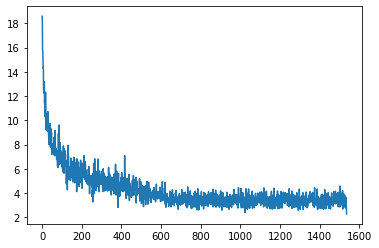

In [73]:
plt.plot([i.item() for i in train_loss_list])

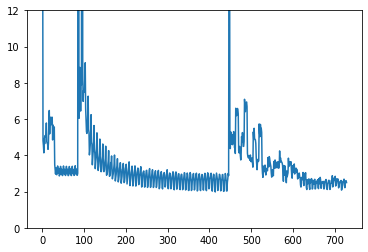

In [74]:
plt.ylim(0.0, 12.0)
plt.plot([i.item() for i in val_loss_list])

In [75]:
trainer.test(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 48.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.5007641315460205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.5007641315460205}]

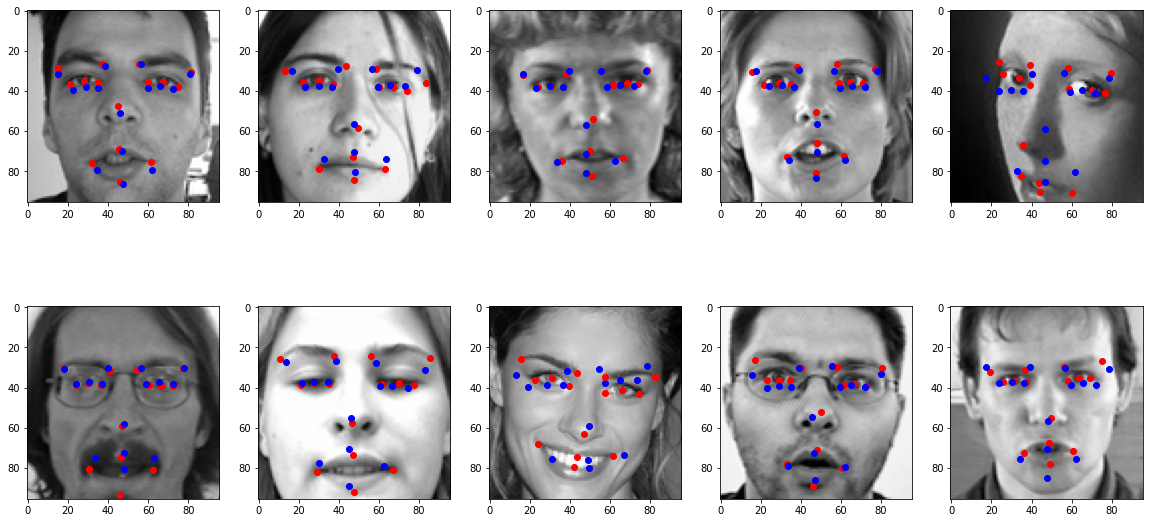

In [77]:
draw_validout(model)

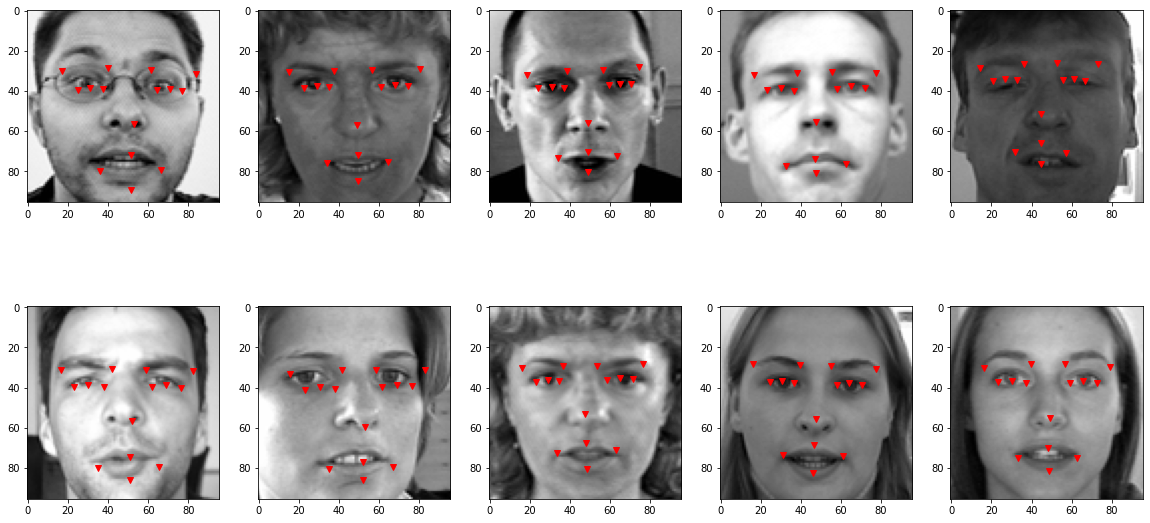

In [154]:
draw_testout(model)

In [76]:
save_res(model) # 4.01170